In [2]:
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

# from miniai.training import *

In [3]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
logging.disable(logging.WARNING)

# Hugging Face Datasets

In [6]:
load_dataset_builder

<function datasets.load.load_dataset_builder(path: str, name: Union[str, NoneType] = None, data_dir: Union[str, NoneType] = None, data_files: Union[str, Sequence[str], Mapping[str, Union[str, Sequence[str]]], NoneType] = None, cache_dir: Union[str, NoneType] = None, features: Union[datasets.features.features.Features, NoneType] = None, download_config: Union[datasets.download.download_config.DownloadConfig, NoneType] = None, download_mode: Union[datasets.download.download_manager.DownloadMode, str, NoneType] = None, revision: Union[str, datasets.utils.version.Version, NoneType] = None, use_auth_token: Union[bool, str, NoneType] = None, storage_options: Union[Dict, NoneType] = None, **config_kwargs) -> datasets.builder.DatasetBuilder>

In [7]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [8]:
ds_builder

In [9]:
ds_builder.info

DatasetInfo(description="Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of\n60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,\nassociated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in\nreplacement for the original MNIST dataset for benchmarking machine learning algorithms.\nIt shares the same image size and structure of training and testing splits.\n", citation='@article{DBLP:journals/corr/abs-1708-07747,\n  author    = {Han Xiao and\n               Kashif Rasul and\n               Roland Vollgraf},\n  title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning\n               Algorithms},\n  journal   = {CoRR},\n  volume    = {abs/1708.07747},\n  year      = {2017},\n  url       = {http://arxiv.org/abs/1708.07747},\n  archivePrefix = {arXiv},\n  eprint    = {1708.07747},\n  timestamp = {Mon, 13 Aug 2018 16:47:27 +0200},\n  biburl    = {https://dbl

In [10]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [12]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [13]:
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to C:/Users/User/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [15]:
dsd["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [16]:
dsd["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F58F9B640>,
 'label': 9}

In [18]:
dsd["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [19]:
dsd["train"].features["image"]

Image(decode=True, id=None)

In [21]:
dsd["train"]["image"][:5]

[<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5A8A30>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5A8910>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5A8160>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5A8A90>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5A8A60>]

In [22]:
train,test = dsd["train"],dsd["test"]
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F69C42DC0>,
 'label': 9}

In [23]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [24]:
x,y = ds_builder.info.features
x,y

('image', 'label')

In [25]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F66992CD0>,
 'label': 9}

In [30]:
train[0][x]

In [31]:
train[:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5ADE80>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5ADD90>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5ADD00>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5ADC70>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5ADDF0>],
 'label': [9, 0, 0, 3, 0]}

In [32]:
train[:5][x]

[<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5ADF40>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5AD8E0>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5AD7C0>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5AD1F0>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x4F5F5AD8B0>]

In [33]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [35]:
train.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [37]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [38]:
yb

[9, 0, 0, 3, 0]

In [44]:
featy.names

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [39]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [51]:
TF

<module 'torchvision.transforms.functional' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\torchvision\\transforms\\functional.py'>

In [53]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

In [54]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [58]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

**OR**

In [63]:
train[0][x]

In [65]:
x_to_tensor = TF.to_tensor(train[0][x])
x_to_tensor.shape

torch.Size([1, 28, 28])

In [75]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [76]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [77]:
x_to_tensor_flat = torch.flatten(TF.to_tensor(train[0][x]))
x_to_tensor_flat.shape

torch.Size([784])

In [78]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [81]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [82]:
inplace

<function __main__.inplace(f)>

In [86]:
_transformi

<function __main__._transformi(b)>

In [87]:
transformi = inplace(_transformi)

In [90]:
transformi

<function __main__.inplace.<locals>._f(b)>

In [88]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [91]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [108]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [109]:
d = dict(a=1,b=2,c=3)
d

{'a': 1, 'b': 2, 'c': 3}

In [110]:
itemgetter

operator.itemgetter

In [112]:
ig = itemgetter("a","c")
ig

operator.itemgetter('a', 'c')

In [113]:
ig(d)

(1, 3)

In [115]:
class D:
    def __getitem__(self,k): return 1 if k=="a" else 2 if k=="b" else 3

In [117]:
ig

operator.itemgetter('a', 'c')

In [116]:
d = D()
ig(d)

(1, 3)

In [118]:
tdsf

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [119]:
list(tdsf.features)

['image', 'label']

In [121]:
default_collate

<function torch.utils.data._utils.collate.default_collate(batch)>

In [123]:
batch = dict(a=[1], b=[2]), dict(a=[3],b=[4])
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

In [124]:
batch[0]

{'a': [1], 'b': [2]}

In [125]:
batch[1]

{'a': [3], 'b': [4]}

In [126]:
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [129]:
tdsf

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [127]:
list(tdsf.features)

['image', 'label']

In [128]:
itemgetter(tdsf.features)

operator.itemgetter({'image': Image(decode=True, id=None), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)})

In [132]:
get = itemgetter(*tdsf.features)
get

operator.itemgetter('image', 'label')

In [142]:
def _res(b): return get(default_collate(b))

In [146]:
final_rs = _res(tdsf)

In [154]:
final_rs[0].shape, final_rs[1].shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [134]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [138]:
type(tdsf)

datasets.arrow_dataset.Dataset

In [155]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

## Plotting images

In [242]:
dl

(torch.Size([28, 28]), torch.Size([28, 28]))

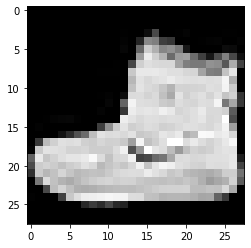

In [171]:
b = next(iter(dl))
xb = b["image"]
img = xb[0]
plt.imshow(img[0])

img[0].shape, img.squeeze().shape

In [173]:
fc.delegates

<function fastcore.meta.delegates(to: function = None, keep=False, but: list = None)>

fc.delegates --> "Decorator: replace `**kwargs` in signature with params from `to`"

In [176]:
plt.Axes.imshow

<function matplotlib.axes._axes.Axes.imshow(self, X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

In [186]:
xb.shape, len(xb.shape), xb.ndim

(torch.Size([4, 1, 28, 28]), 4, 4)

In [191]:
plt.subplots??

In [192]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [193]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



In [194]:
img.shape

torch.Size([1, 28, 28])

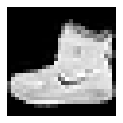

In [197]:
show_image(img, figsize=(2,2));

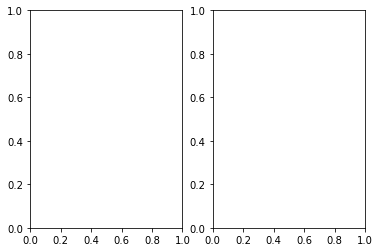

In [198]:
fig,axs = plt.subplots(1,2)

In [201]:
axs

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

<AxesSubplot:>

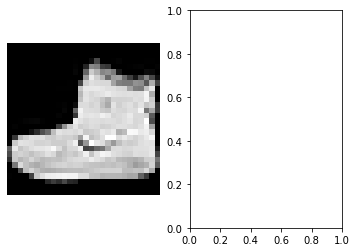

In [202]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])

In [207]:
img2 = xb[1]
img2.shape

torch.Size([1, 28, 28])

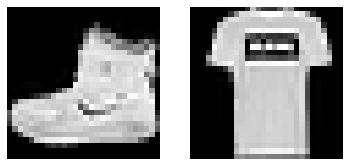

In [210]:
fig,axs = plt.subplots(1,2)
a =show_image(img, axs[0])
b =show_image(img2, axs[1]);

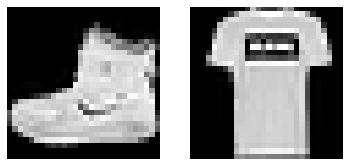

In [212]:
a.figure

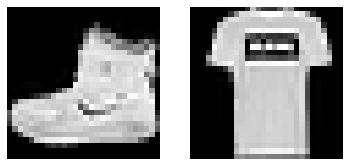

In [213]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(img2, axs[1]);

In [216]:
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [217]:
help(subplots)

Help on function subplots in module __main__:

subplots(nrows: 'int' = 1, ncols: 'int' = 1, figsize: 'tuple' = None, imsize: 'int' = 3, suptitle: 'str' = None, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **kwargs)
    A figure and set of subplots to display images of `imsize` inches



In [218]:
from nbdev.showdoc import show_doc

In [219]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

In [246]:
b = next(iter(dl))
xb = b['image']
xb.shape

torch.Size([4, 1, 28, 28])

In [251]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
xb = b['image']
xb.shape

torch.Size([16, 1, 28, 28])

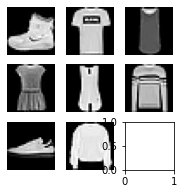

In [252]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat, imgs): show_image(img, ax)

In [253]:
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

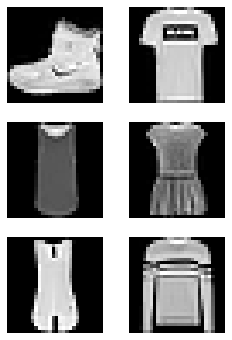

In [257]:
fig,axs = get_grid(8, nrows=3, imsize=2)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [258]:
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [260]:
b["label"].shape

torch.Size([16])

In [262]:
yb = b["label"]
lbls = yb[:8]
lbls

tensor([9, 0, 0, 3, 0, 2, 7, 2])

In [267]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
" ".join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

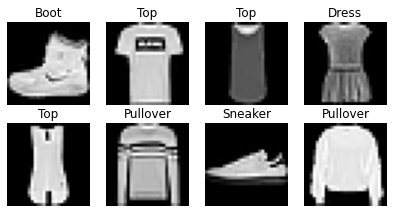

In [268]:
show_images(imgs, imsize=1.7, titles=titles)

In [275]:
# classmethod??

In [276]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))